# NYC Airbnb 2019: End-to-End Regression Project


<div class="alert alert-info">
<h2> ABSTRACT </h2>
</div>  

This project aims to predict Airbnb listing popularity in New York City by modeling the number of monthly reviews (reviews_per_month) each listing receives. We hypothesize that features such as geographic location, host activities, and property attributes, together with additional engineered features like review timing and text sentiment, will help explain variation in listing popularity. To achieve our goal, we compare multiple regression models—Ridge, Random Forest, LightGBM, and Elastic Net—seeking a balance between accuracy, interpretability, and computational efficiency.

<div class="alert alert-info">
    <h2> INTRODUCTION </h2>
</div>  


<div class="alert alert-warning">
    <h3> Problem Statement  </h3>
</div>  

The central objective of this project is to forecast the popularity of Airbnb listings in New York City, represented by the number of reviews a listing receives per month. We interpret higher review counts as a proxy for greater popularity or demand, enabling us to understand how various factors—location, listing attributes, host behavior, and time of year—might drive a listing’s success. Ultimately, this predictive model can inform Airbnb hosts about strategic ways to optimize their listings and appeal to prospective renters.

<div class="alert alert-warning">
    <h3> Data  </h3>
</div>  
The data contains 9 explanatory features and one target feature `reviews_per_month`, which will be used as a metric for a listing's popularity. Some observations for `reviews_per_month` were missing; however, this is because they were linked to `number_of_reviews` having values of 0 and therefore can be imputed.

Listing popularity is likely to be dependent on the location, availability throughout the year, any restrictions (e.g. minimum nights, price), and properties of a listing (e.g. room type). Features that are less likely to contribute to the prediction model's learning are: `id`, `host_id` and `host_name` as these are unique and likely will not provide meaninglful patterns or contribute to the model's good generalization. The `name` feature (the name of the listing) is also unique; however, there could be potentially useful features extracted from it, and will be explored in this project.

Geographical features such as `neighbourhood_group`, `neighbourhood`, `lattitude` and `longtitude` should be examined for any high correlations, as these features may contribute the same amount of information to the model.

Date feature `last_review` could be used to analyze seasonal patterns in the listing's popularity.


<div class="alert alert-warning">
    <h3> Models  </h3>
</div>    
This regression problem is approached through four primary models:

- **Ridge Regression**  
  Offers simplicity and interpretability, making it useful for understanding how features individually influence monthly review counts.  
- **Random Forest**  
  Excels at detecting complex, non-linear relationships and interactions among features, though it can be more computationally expensive and prone to overfitting if not regularized carefully.  
- **LightGBM (LGBM)**  
  Known for its speed and efficiency when dealing with large datasets, as well as built-in regularization and handling of sparse data.  
- **Elastic Net**  
  Combines L1 (lasso) and L2 (ridge) penalties, aiding in feature selection while mitigating overfitting, especially useful when many features are correlated.

By experimenting with these models, we aim to identify the best balance of predictive power, computational cost, and interpretability. As we refine the data (e.g., imputing, encoding categorical features, standardizing numeric features), we will compare each model’s performance via appropriate metrics—such as $R^2$ and Mean Absolute Error (MAE)—and select the approach that most robustly generalizes to unseen listings.

In [13]:
# Run command for helper functions
%run -i ../src/pipeline_maker.py
%run -i ../src/evaluate.py
%run -i ../src/interpretation.py
%run -i ../src/feat_engineer.py
%run -i ../src/eda.py
%run -i ../src/random_search.py

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/farhan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/farhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
import pandas as pd
import numpy as np
import pickle
import shap
from scipy.stats import loguniform

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from IPython.display import Image, display

<div class="alert alert-info">
<h2> METHODS </h2>
</div>  

We begin with exploratory data analysis (EDA) to gain a clearer understanding of the dataset and identify potential trends or anomalies. Next, we perform any necessary feature engineering before handling missing values and preparing our data (e.g., encoding categorical variables and scaling numeric features).  

With our cleaned and transformed dataset, we then fit and evaluate several models—namely Ridge Regression, Random Forest, LightGBM, and Elastic Net—using appropriate metrics (e.g., \(R^2\), MAE) to assess performance. Finally, we optimize hyperparameters for each candidate model and compare their performance on the test set to determine the best overall approach.

In [15]:
data = pd.read_csv('../data/raw/AB_NYC_2019.csv')
data['reviews_per_month'] = data['reviews_per_month'].apply(lambda x: 0 if pd.isna(x) else x)
train_df, test_df = train_test_split(data, random_state=573)

<div class="alert alert-warning">
    <h3> Exploratory Data Analysis  </h3>
</div>  

**SUMMARY STATISTICS (using describe() method)**
- Mean `reviews_per_month`: An average of 1.086 reviews per month suggests limited interaction for most listings.
- Most features have outliers and widely different ranges (as we will see again in the histograms). As such, using a standard scalar for numeric features would be a good idea.

**FEATURE DISTRIBUTION PLOTS**
- Numeric features and the target variables have highly skewed distributions. Therefore, a 'median' strategy for imputation (if needed) will be more appropriate than the mean, as it is less affected by outliers. 
- The features also have very different ranges. As such we will use a standard scalr to resolve thhis issue.  

**UNIQUE COUNTS (using nunique() method)**
- Unique count is important for categorical features. We see host_id and id are unique and they will be dropped. The neighbourhood column seems to have more than 200 unique values. This will slightly explode our feature count after one hot encoding. We will test our pipelines with both using this feature (with feature selection) and not using this feature. Since we will not be including all of our testing in this report, the final report may not have this feature.

**FEATURE-FEATURE CORRELATIONS**
- We see high feature-feature correlations between host_id and id. We were already dropping both these features due to their uniqueness
- We also see a high correlation between the target (`number_of_reviews`) and our feature `reviews_per_month`. This correlation makes intuitive sense and therefore we will not be dropping this feature.

**MISSING VALUES (using info() method)**
- Our `reviews_per_month` or target column had roughly 7000 missing values. But we found out this was due to `number_of_reviews` being zero. As such we were able to 'impute' the target values for all observations. 
- The `last_review` feature will be used to extract the month of last review. This column has some missing values which should be imputed after feature engineering.
- A small few amount of `names` and `host_names` also had missing values

**SCORING METRICS**
- Since our target distribution is skewed and may have potential outliers, we will use MAE as it is easier to interpret and is less affected by outliers. Additionally, it will provide a better measure of absolute accuracy of the predictions.
- We will also use $R^2$ as it provides an interpretable result for assessing goodness of fit.

In [16]:
train_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.667100e+04,3.667100e+04,36671.000000,36671.000000,36671.000000,36671.000000,36671.000000,36671.000000,36671.000000,36671.000000
mean,1.901858e+07,6.753485e+07,40.728871,-73.952174,153.009408,7.017398,23.086990,1.086294,7.155109,112.255897
std,1.099541e+07,7.862213e+07,0.054648,0.046113,247.269517,20.734663,44.304601,1.593990,33.242306,131.558583
min,3.647000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.453066e+06,7.848642e+06,40.689930,-73.983090,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.968643e+07,3.091859e+07,40.722830,-73.955680,105.000000,2.000000,5.000000,0.370000,1.000000,44.000000
75%,2.917369e+07,1.074344e+08,40.763125,-73.936160,175.000000,5.000000,23.000000,1.570000,2.000000,225.000000
max,3.648543e+07,2.743213e+08,40.912340,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36671 entries, 4888 to 9822
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              36671 non-null  int64  
 1   name                            36658 non-null  object 
 2   host_id                         36671 non-null  int64  
 3   host_name                       36656 non-null  object 
 4   neighbourhood_group             36671 non-null  object 
 5   neighbourhood                   36671 non-null  object 
 6   latitude                        36671 non-null  float64
 7   longitude                       36671 non-null  float64
 8   room_type                       36671 non-null  object 
 9   price                           36671 non-null  int64  
 10  minimum_nights                  36671 non-null  int64  
 11  number_of_reviews               36671 non-null  int64  
 12  last_review                     291

In [18]:
train_df.nunique()

id                                36671
name                              36058
host_id                           29147
host_name                          9556
neighbourhood_group                   5
neighbourhood                       220
latitude                          16986
longitude                         13226
room_type                             3
price                               617
minimum_nights                       97
number_of_reviews                   364
last_review                        1710
reviews_per_month                   890
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [19]:
save_distribution_charts(train_df)

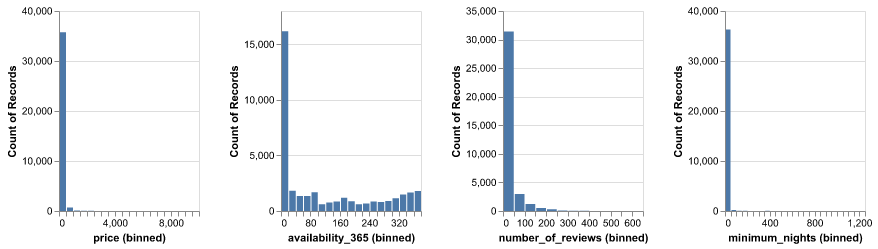

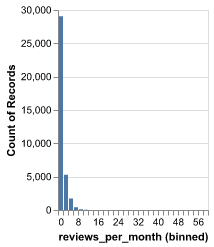

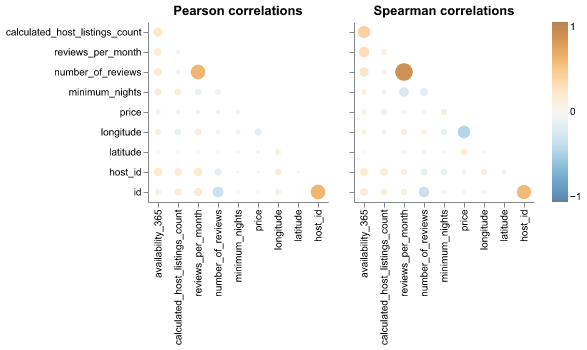

In [20]:
display(Image(filename='../results/figures/feature_dist_chart.png'))
display(Image(filename='../results/figures/target_dist_chart.png'))
display(Image(filename='../results/figures/corr.png'))


<div class="alert alert-warning">
    <h3> Feature Engineering  </h3>
</div>  

**We wil introduce two new features:**
1. Vader sentiment analysis on the name of the listings. 
    - Motivation: listings with positive or engaging titles may attract more guests, and hence more reviews, while negative sentiments might deter potential renters.
2. Month of the listing from `last_review`. 
    - Motivation: the month information can help identify any seasonal patterns in the listing's popularity, as certain months may see higher booking rates, which can lead to more reviews.

In [21]:
train_df, test_df = add_name_polarity_scores(train_df, test_df)
train_df, test_df = add_month_of_last_review(train_df, test_df)

<div class="alert alert-warning">
    <h3> Preprocessing and transformations  </h3>
</div>  

In [22]:
X_train = train_df.drop(columns='reviews_per_month')
y_train = train_df['reviews_per_month']
X_test = test_df.drop(columns='reviews_per_month')
y_test = test_df['reviews_per_month']

In [23]:
categorical_features = ['neighbourhood_group', 'room_type', 'month_of_last_review']
numeric_features = ['latitude', 
                'longitude', 
                'minimum_nights', 
                'number_of_reviews', 
                'calculated_host_listings_count', 
                'availability_365',
                'name_polarity_scores'
                ]
drop_features = ['id', 'host_id', 'host_name', 'name', 'neighbourhood']

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"), 
    StandardScaler()
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features)
)

In [24]:
preprocessor.fit(X_train) 

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['latitude', 'longitude', 'minimum_nights',
                                  'number_of_reviews',
                                  'calculated_host_listings_count',
                                  'availability_365', 'name_polarity_scores']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['neighbourhood_group', 'room_type',
                                  'month_of_last_review']),
                                ('drop', 'drop',
                                 ['id', 'host_id', 'host_name', 'name',
                                  'neighbourhood'])])

<div class="alert alert-warning">
    <h3> Baseline model  </h3>
</div>  

In [25]:
results = {}
scoring_metric = {
    "R2": "r2",
    "Neg MAE": "neg_mean_absolute_error",
}

In [26]:
dummy = make_dummy_pipeline(X_train, y_train, preprocessor, results, scoring_metric)
pd.DataFrame(results).T

,fit_time,score_time,test_R2,train_R2,test_Neg MAE,train_Neg MAE
Dummy,0.005 (+/- 0.002),0.001 (+/- 0.000),-0.000 (+/- 0.000),0.000 (+/- 0.000),-1.145 (+/- 0.007),-1.145 (+/- 0.002)


The dummy model shows poor performance, as expected, indicating that predicting the average value of the target variable `reviews_per_month` (1.09) for all observations does not capture the complexity of the problem.

<div class="alert alert-warning">
    <h3>  Linear model  </h3>
</div> 

We will start by exploring the Ridge model. To optimize its performance, we will use RidgeCV, which automatically tunes the regularization hyperparameter (alpha) using cross-validation. This process allows us to dynamically identify the best alpha within overall cross-validation. See cross validation results below.<br>

The cross-validation results show an improved $R2$ score of 0.52, indicating that the model can explain approximately 52% of the variance in the target variable, reviews_per_month. While this represents a significant improvement over the baseline dummy model, the performance is still moderate and leaves room for enhancement. Further refinements, such as feature engineering or hyperparameter tuning, may help improve the model's predictive power.

Additionally, the Mean Absolute Error (MAE) of 0.62 is better than that of the dummy model, meaning the model’s predictions deviate, on average, by about 0.62 reviews per month from the actual values. Considering that the average reviews_per_month is 1.08, this deviation is approximately 60% of the mean value. While the reduction in error is promising, the discrepancy highlights opportunities for further optimization to better align predictions with actual values.

In [27]:
# RidgeCV has built in hyperparameter optimization
alpha_vals =  np.logspace(-8, 8, 10)
ridge = make_ridge_pipeline(X_train, y_train, preprocessor, results, alpha_vals, scoring_metric)

In [28]:
pd.DataFrame(results).T

,fit_time,score_time,test_R2,train_R2,test_Neg MAE,train_Neg MAE
Dummy,0.005 (+/- 0.002),0.001 (+/- 0.000),-0.000 (+/- 0.000),0.000 (+/- 0.000),-1.145 (+/- 0.007),-1.145 (+/- 0.002)
RidgeCV,0.467 (+/- 0.026),0.006 (+/- 0.000),0.519 (+/- 0.032),0.518 (+/- 0.009),-0.622 (+/- 0.007),-0.622 (+/- 0.002)


<div class="alert alert-warning">
    <h3>  Ensemble Models  </h3>
</div> 

#### LGBM Regressor
The LightGBM (LGBM) model achieved a train $R^2$ of 0.74 and a CV $R^2$ of 0.66. This is not a significant deviation, indicating that the model is not that heavily overfitting. Both the train and CV $R^2$ scores are higher than those of Ridge regression, suggesting that LGBM is better at capturing the data patterns and generalizes more effectively than Ridge.

A similar trend is observed in the MAE (Mean Absolute Error) scores. The CV and train MAE scores for LGBM are -0.484 (+/- 0.011) and -0.441 (+/- 0.004), respectively, which are significantly lower than those of Ridge. This implies that the LGBM model's predictions deviate, on average, by approximately 0.484 reviews per month—an improvement over Ridge.

However, LGBM's fit time is 0.851, which is higher than Ridge's fit time of 0.685, indicating that LGBM is computationally more expensive. Despite the higher computational cost, LGBM outperforms Ridge in terms of capturing data patterns and providing better predictions, making it a more effective model overall for this task.

#### Random Forest
The Random Forest model achieved a train $R^2$ of 0.949 and a test $R^2$ of 0.638. The relatively larger deviation between train and test $R^2$ scores suggests some overfitting, as Random Forest tends to excel in capturing data patterns but may struggle to generalize when compared to RidgeCV, which had train and test $R^2$ scores of 0.518 and 0.519, respectively. However, Random Forest still performs better on the test $R^2$ metric, indicating its ability to capture more complex patterns in the data.

In terms of MAE (Mean Absolute Error), Random Forest significantly outperforms RidgeCV. The test MAE score for Random Forest is -0.486 (+/- 0.010), compared to RidgeCV's -0.622 (+/- 0.007), meaning Random Forest's predictions deviate less, on average, by approximately 0.486 reviews per month. The train MAE for Random Forest is even better at -0.181 (+/- 0.002), showing it fits the training data exceptionally well, though at the cost of potential overfitting.

The downside of Random Forest is its computational expense. It has a fit time of 4.470 seconds, which is significantly higher than RidgeCV's 0.685 . Its score time is also longer at 0.072 compared to RidgeCV's 0.009. This makes Random Forest less efficient for scenarios requiring rapid model training or scoring.

#### Elastic Net
The Elastic Net model achieved train and test $R^2$ scores of 0.518 and 0.521, respectively, which are very similar to those of RidgeCV (train $R^2$: 0.518, test $R^2$: 0.519). This similarity indicates Elastic Net and RidgeCV perform comparably in terms of capturing patterns in the data.

In terms of MAE (Mean Absolute Error), Elastic Net and RidgeCV also show minimal differences. Elastic Net's test MAE is -0.622 (+/- 0.012), almost identical to RidgeCV's -0.622 (+/- 0.007). Similarly, the train MAE for Elastic Net (-0.621 (+/- 0.002)) is nearly the same as RidgeCV's (-0.622 (+/- 0.002)). This indicates that both models predict with the same level of average error on the test and training sets.

Elastic Net has a slight computational advantage over RidgeCV. It has a fit time of 0.505 (+/- 0.067), compared to RidgeCV's 0.685 (+/- 0.039). The score time for Elastic Net is also marginally lower at 0.008 (+/- 0.002), compared to RidgeCV's 0.009 (+/- 0.001). This makes Elastic Net slightly more efficient, especially for large-scale applications requiring faster model training.


In [29]:
lgbm_pipe =  make_lgbm_pipeline(X_train, y_train, preprocessor, results, scoring_metric)
rf_pipe =  make_rf_pipeline(X_train, y_train, preprocessor, results, scoring_metric)
elastic_pipe = make_elastic_pipeline(X_train, y_train, preprocessor, results, scoring_metric)
pd.DataFrame(results).T

,fit_time,score_time,test_R2,train_R2,test_Neg MAE,train_Neg MAE
Dummy,0.005 (+/- 0.002),0.001 (+/- 0.000),-0.000 (+/- 0.000),0.000 (+/- 0.000),-1.145 (+/- 0.007),-1.145 (+/- 0.002)
RidgeCV,0.467 (+/- 0.026),0.006 (+/- 0.000),0.519 (+/- 0.032),0.518 (+/- 0.009),-0.622 (+/- 0.007),-0.622 (+/- 0.002)
lgbm,0.363 (+/- 0.017),0.014 (+/- 0.000),0.661 (+/- 0.038),0.736 (+/- 0.006),-0.484 (+/- 0.011),-0.441 (+/- 0.004)
random_forests,2.218 (+/- 0.157),0.048 (+/- 0.006),0.638 (+/- 0.035),0.949 (+/- 0.002),-0.486 (+/- 0.010),-0.181 (+/- 0.002)
elastic_net,0.310 (+/- 0.018),0.005 (+/- 0.001),0.521 (+/- 0.037),0.518 (+/- 0.005),-0.622 (+/- 0.012),-0.621 (+/- 0.002)


<div class="alert alert-warning">
    <h3>  Feature selection  </h3>
</div> 

Here, we test out our neighbourhood categorical feature followed by feature selection using RFE CV. 

In [24]:
rfe_ridge_categorical_features = ['neighbourhood_group', 'room_type', 'month_of_last_review', 'neighbourhood']

rfe_ridge_drop_features = ['id', 'host_id', 'host_name', 'name']

rfe_ridge_preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, rfe_ridge_categorical_features),
    ("drop", rfe_ridge_drop_features)
)

In [ ]:
# Make the rfecv pipeline
pipe_rfe_ridgecv = make_pipeline(
    rfe_ridge_preprocessor,
    RFECV(Ridge(), cv=10, n_jobs=-1), 
    RidgeCV()
)

# Get the cv scores
results['rfe_ridgecv'] = mean_std_cross_val_scores(
    pipe_rfe_ridgecv, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [32]:
pd.DataFrame(results).T

,fit_time,score_time,test_R2,train_R2,test_Neg MAE,train_Neg MAE
Dummy,0.002 (+/- 0.000),0.000 (+/- 0.000),-0.000 (+/- 0.000),0.000 (+/- 0.000),-1.145 (+/- 0.007),-1.145 (+/- 0.002)
RidgeCV,0.299 (+/- 0.003),0.004 (+/- 0.000),0.519 (+/- 0.032),0.518 (+/- 0.009),-0.622 (+/- 0.007),-0.622 (+/- 0.002)
lgbm,0.612 (+/- 0.003),0.007 (+/- 0.000),0.661 (+/- 0.038),0.736 (+/- 0.006),-0.484 (+/- 0.011),-0.441 (+/- 0.004)
random_forests,0.836 (+/- 0.040),0.026 (+/- 0.007),0.638 (+/- 0.035),0.949 (+/- 0.002),-0.486 (+/- 0.010),-0.181 (+/- 0.002)
elastic_net,0.211 (+/- 0.004),0.003 (+/- 0.000),0.521 (+/- 0.037),0.518 (+/- 0.005),-0.622 (+/- 0.012),-0.621 (+/- 0.002)
rfe_ridgecv,9.476 (+/- 0.585),0.012 (+/- 0.001),0.528 (+/- 0.030),0.532 (+/- 0.008),-0.630 (+/- 0.006),-0.626 (+/- 0.003)


We observed that adding the neighborhood feature followed by feature selection slightly improved the performance of RidgeCV, as evidenced by the higher R² scores. However, the increased fit times indicate significant computational demands, which, in our opinion, do not justify the marginal improvement.

While we believe that incorporating the neighborhood feature followed by Recursive Feature Elimination (RFE) could marginally enhance the performance of other models as well, we opted not to pursue this approach for this project. The high fit times render it impractical and infeasible given the scope and computational constraints.

<div class="alert alert-warning">
    <h3>  Hyperparameter optimization  </h3>
</div> 

We performed hyperparameter optimization on Ridge, LGBTM, Random Forest and Elastic Net models using RandomizesSearchCV method of sklearn. Below is the summary of results:

- Ridge: Optimized the alpha hyperparameter. Best $\alpha$ = 13.49, with $R^2$ score being 0.52, which is similar to our linear model in Section 7. This is expected since RidgeCV (from section 7) already had built in hyperparameter optimization for $\alpha$.  

- LGBM: Optimized learning_rate, max_depth and n_estimators hyperparameters. Best values are 0.05, 50 and 200 respectively, with $R^2$ score of 0.66, which is similar to the initial model in section 8.  

- Random Forest: Optimized max_depth and n_estimators hyperparameters. Best values are 16 and 345 respectively, with $R^2$ score of 0.64 which is also similar to the initial model.

- Elastic Net: Optimimized L1 ratio and alpha hyperparameters. Best values are 0.1 and all alphas chosen that were passed. The new is 0.48, which is considerably worse than the base model in section 8. This could be due to a faulty range of hyperparameter values passed into random search.

In [30]:
opti_results = {}

param_dist_ridge = {
    "ridgecv__alphas": loguniform(1e-5, 1e5)    
}

param_grid_rf = {
    "randomforestregressor__max_depth": np.linspace(2, 20, 10, dtype=int),
    "randomforestregressor__n_estimators": np.linspace(10, 500, 20, dtype=int)
}

param_grid_lgbm =  {
    "lgbmregressor__learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "lgbmregressor__max_depth": [10,50,100],
    "lgbmregressor__n_estimators": [100,150,200]
}

param_grid_elastic = {
    "elasticnetcv__l1_ratio": np.linspace(0.1, 1.0, 10),
    "elasticnetcv__alphas": [[0.1, 1.0, 10.0, 100.0]],
}

In [31]:
random_ridge_search = run_ridge_random_search(X_train, y_train, preprocessor,
    param_dist_ridge, scoring_metric='r2', n_iter=1,
    refit_metric='R2', random_state=573, opti_results=opti_results
)

In [32]:
random_lgbm_search = run_lgbm_random_search(X_train, y_train, preprocessor, param_grid_lgbm, 
    scoring_metric='r2', n_iter=1, refit_metric='R2', 
    random_state=573, opti_results=opti_results
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003947 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003946 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 1419
[LightGBM] [Info] Total Bins 1417
[LightGBM] [Info] Total Bins 1415
[LightGBM] [Info] Number of data points in the train set: 29337, number of used features: 28[LightGBM] [Info] Number of data points in the train set: 29337, number of used features: 28

[LightGBM] [Info] Number of data points in the train set: 29337, number of used features: 28
[LightGBM] [Info] Start training from score 1.088227
[LightGBM] [Info] Start training from score 1.086966
[LightGBM] [Info] Start tra

In [33]:
random_rf_search = run_rf_random_search(X_train, y_train, preprocessor, param_grid_rf, 
    scoring_metric='r2', n_iter=1, refit_metric='R2', 
    random_state=573, opti_results=opti_results
)

In [34]:
random_en_search = run_elastic_net_random_search(X_train, y_train, preprocessor, param_grid_elastic,
    scoring_metric='r2', n_iter=1, refit_metric='R2',
    random_state=573, cv=5, opti_results=opti_results
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [35]:
pd.DataFrame(opti_results)

,ridge,lgbm,rf,elastic_net
Optimized Train Score (R2),0.517739,0.760163,0.578841,0.437795
Optimized Validation Score (R2),0.518970,0.662092,0.564758,0.439347


In [39]:
pd.DataFrame(opti_results).to_csv('../results/tables/optimized_results.csv')

In [40]:
with open('../results/models/ridge_random.pickle', 'wb') as file:
    pickle.dump(random_ridge_search, file)

with open('../results/models/lgbm_random.pickle', 'wb') as file:
    pickle.dump(random_lgbm_search, file)

with open('../results/models/rf_random.pickle', 'wb') as file:
    pickle.dump(random_rf_search, file)

with open('../results/models/random_en_search.pickle', 'wb') as file:
    pickle.dump(random_en_search, file)

<div class="alert alert-warning">
    <h3>  Interpreting Feature Importance  </h3>
</div> 

Permutation importance evaluates the significance of a feature by measuring the impact on model performance when its values are randomly shuffled. If shuffling a feature significantly reduces the model's accuracy, it indicates high importance. Conversely, minimal change suggests low importance.

For our **LGBM** model, the features with the highest permutation importance are:
- `number_of_reviews`
- `month_of_last_review_July`
- `month_of_last_review_June`
- `minimum_nights`
- `availability_365`
- `calculated_host_listings_count`
- `latitude` and `longitude`

These results align intuitively. Location, listing availability, and the duration of a guest's stay likely influence their experience and review. The prominence of June and July also makes sense, as summer months typically see higher Airbnb activity.

However, it’s important to note that permutation importance reflects the model's internal understanding of features and may not directly represent their real-world causal relationships.

/Users/farhan/Desktop/ECA/Projects/DSCI_573_Lab4_BDFJ/src/interpretation.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


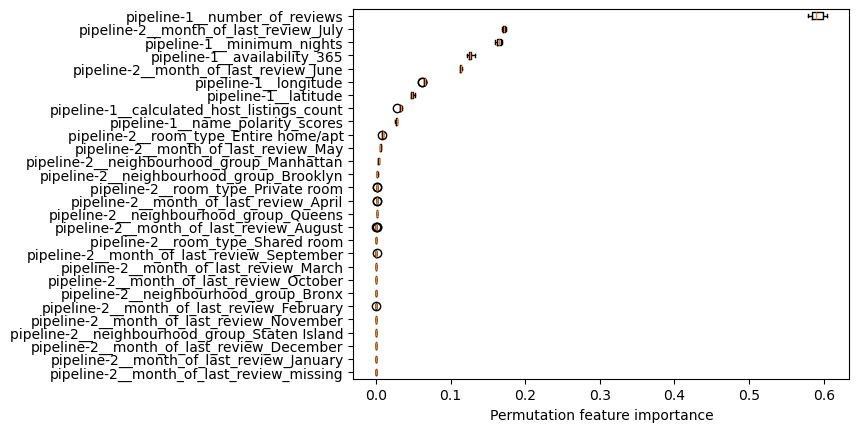

In [45]:
with open('../results/models/lgbm_random.pickle', 'rb') as f:
    random_lgbm_search = pickle.load(f)

get_permutation_importance(random_lgbm_search.best_estimator_)

<div class="alert alert-info">
    <h2> RESULTS </h2>
</div>

<div class="alert alert-warning">
    <h3>  Performance of Best Model (optimized LGBM) on Test Set </h3>
</div> 

In [46]:
best_pipeline, mse, r2 = evaluate_best_pipeline(random_lgbm_search, X_test, y_test)

Mean Squared Error (MSE): 0.7863
R-squared (R²): 0.6955


<div class="alert alert-warning">
    <h3>  Performance of Best Model (optimized LGBM) on CV Set </h3>
</div> 

In [48]:
pd.read_csv('../results/tables/optimized_results.csv')

,Unnamed: 0,ridge,lgbm,rf,elastic_net
0,Optimized Train Score (R2),0.517739,0.760163,0.578841,0.437795
1,Optimized Validation Score (R2),0.518970,0.662092,0.564758,0.439347


<div class="alert alert-warning">
    <h3>  Comparing Test and CV Score </h3>
</div> 

The mean cross-validation (CV) score for our best LGBM model was 0.662, and the test score is 0.693, which is very close. This consistency indicates that the model's performance on unseen data aligns well with its performance during cross-validation.

We trust our results due to multiple reasons. 
- LGBM is an ensemble model, meaning it uses many trees instead of just one, which helps reduce overfitting. Additionally, LGBM incorporates regularization techniques within each tree, further enhancing its ability to generalize. This increases our confidence in the model’s robustness and generalizability.

- For our best estimator, the standard deviation of test scores across the CV folds is only XXX, which is low. This indicates that the performance is consistent across all CV folds and that the mean CV score was not achieved by chance on just one fold. Additionally, our dataset is large, with over 20,000 observations remaining in the training set after preprocessing. This ensures the model sees diverse data during the CV folds, making it unlikely to achieve a high CV score purely by chance. Therefore, we are confident that optimization bias during cross-validation is minimal.

- We ensured that the test set was kept completely separate from the training set at every step of the pipeline, including during feature engineering. This ensures that the test set provides an unbiased measure of our model's performance on unseen data. Additionally, the test score is slightly higher than the mean CV score, which is plausible and within expectation. Therefore, we trust the reliability of our results.

___
SHAP
___

In [49]:
shap.initjs()
%matplotlib inline
y_test_reset, lgbm_explanation =  get_lgbm_explanation(random_lgbm_search, X_test, y_test)
avg_rev_g_2_75_ind = y_test_reset[y_test_reset > 2.75].index.tolist()
avg_rev_l_5_ind = y_test_reset[y_test_reset < 5 ].index.tolist()

ex_g3_index = avg_rev_g_2_75_ind[2]
ex_l5_index = avg_rev_l_5_ind[2]


In [50]:
shap.plots.force(lgbm_explanation[ex_g3_index, :])

For this prediction (`reviews_per_month` = 2.14), features like `availability_365` (-0.6253) and `month_of_last_review_July` (1) contribute to increasing the prediction, while features such as `minimum_nights` (-0.1938) reduce the prediction.

In [51]:
shap.plots.force(lgbm_explanation[ex_l5_index, :])

For this prediction (`reviews_per_month` = -0.00), very few features are pushing the model towards a higher prediction. Features such as `number_of_reviews` (-0.5211), `minimum_nights` (-0.04907) and  `month_of_last_review_June` (0) are pushing the model towards a lower prediction value.

<div class="alert alert-info">
    <h2> CONCLUSION </h2>
</div>

Overall, out of the four models explored, LGBM demonstrated the best $R^2$
scores both before and after hyperparameter optimization, while also showing the least amount of overfitting. Our final LGBM model, with parameters (learning_rate=0.05, max_depth=50, n_estimators=200), achieved an $R^2$ of 0.693 on the test data. While this is not a perfect score, it is quite adequate for predicting the target. The small gap between the train and test scores further indicates that the model generalizes well.

The SHAP test, showed that native feaatures as number_of_reviews, minimum_nights as well as our engineered feature month_of_last_review have the highest feature importances in predicting the target.

### Other Ideas
As seen in our report, the hyperparameter optimization did yield somewhat better results. To potentially see further improvements in the scores we could explore the following ideas:

1. Evaluate other ensemble models such as XGBoost and CatBoost, which may have better handling of categorical features or more robust regularization.

2. Engineer more and better features. 

3. From the SHAP test, we observe that latitude was assigned some importance, suggesting that geographical location does influence the listing's popularity. Although the neighbourhood feature was excluded due to the many unique values, exploring other possible groupings based on latitude (e.g., dividing regions into categories or clustering listings by proximity) could help capture additional patterns.

4. Expand hyperparameter optimization ranges